# Covid19 Machine Learning Prediction and Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from statsmodels.tsa.api import Holt

In [2]:
covid = pd.read_csv('./downloads/covid_19_data.csv')

In [3]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
print('Size of dataset',covid.shape)
print('Checking for null values',covid.isnull().sum())
print('Checking Data-type',covid.dtypes)

Size of dataset (18327, 8)
Checking for null values SNo                   0
ObservationDate       0
Province/State     9277
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64
Checking Data-type SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


Dropping the columns 

In [5]:
covid.drop(['SNo'],1,inplace=True)

In [6]:
covid.isnull().sum()

ObservationDate       0
Province/State     9277
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

In [7]:
covid['ObservationDate']= pd.to_datetime(covid['ObservationDate'])

Grouping different types of cases as per the date

In [8]:
datewise = covid.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
print(datewise)

                 Confirmed  Recovered    Deaths
ObservationDate                                
2020-01-22           555.0       28.0      17.0
2020-01-23           653.0       30.0      18.0
2020-01-24           941.0       36.0      26.0
2020-01-25          1438.0       39.0      42.0
2020-01-26          2118.0       52.0      56.0
...                    ...        ...       ...
2020-04-20       2472259.0   645738.0  169986.0
2020-04-21       2549123.0   679819.0  176583.0
2020-04-22       2623960.0   709694.0  183066.0
2020-04-23       2708885.0   738486.0  190858.0
2020-04-24       2811193.0   793601.0  197159.0

[94 rows x 3 columns]


In [9]:
print('Basic Information')
print('Total number of Confirmed cases around the world',datewise['Confirmed'].iloc[-1])
print('Total number of Recovered cases around the world',datewise['Recovered'].iloc[-1])
print('Total number of Death cases around the world',datewise['Deaths'].iloc[-1])
print('Total number of Active cases around the world',(datewise['Confirmed'].iloc[-1]-datewise['Recovered'].iloc[-1]))
print('Total number of Closed cases around the world',(datewise['Recovered'].iloc[-1]+datewise['Deaths'].iloc[-1]))


Basic Information
Total number of Confirmed cases around the world 2811193.0
Total number of Recovered cases around the world 793601.0
Total number of Death cases around the world 197159.0
Total number of Active cases around the world 2017592.0
Total number of Closed cases around the world 990760.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),
 <a list of 94 Text xticklabel objects>)

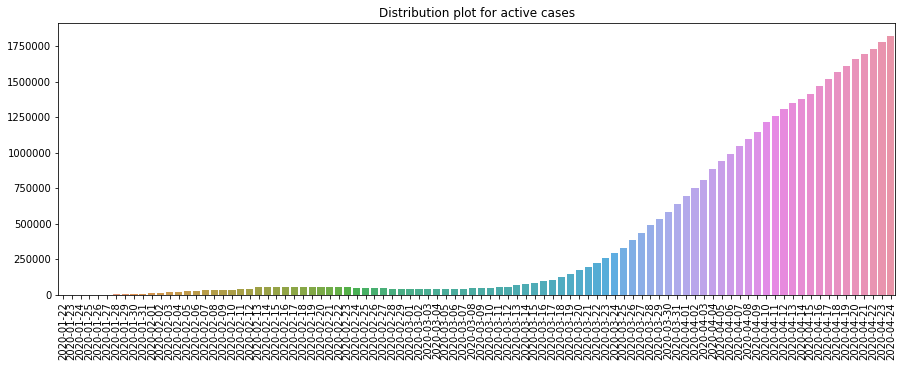

In [10]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise.index.date,y=datewise['Confirmed']-datewise['Recovered']-datewise['Deaths'])
plt.title('Distribution plot for active cases')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),
 <a list of 94 Text xticklabel objects>)

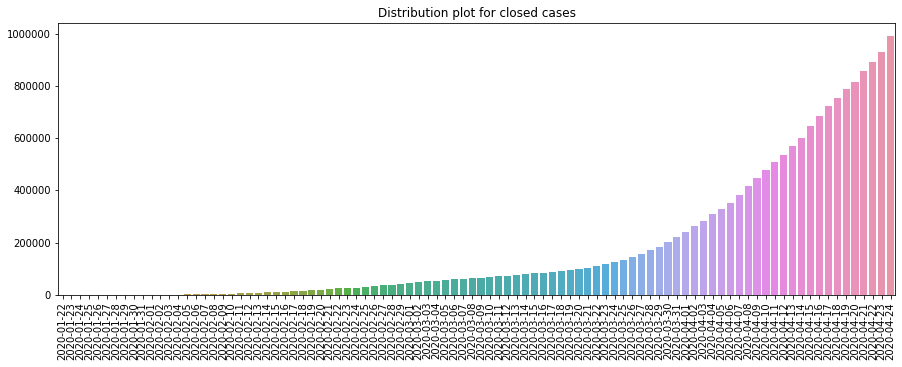

In [11]:
plt.figure(figsize=(15,5))
sns.barplot(x=datewise.index.date,y=datewise['Recovered']+datewise['Deaths'])
plt.title('Distribution plot for closed cases')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Weekly progress of different types of cases')

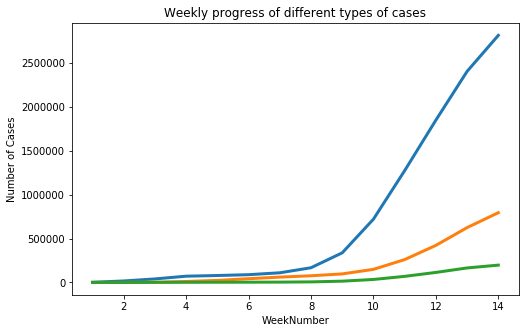

In [12]:
datewise['WeekofYear'] = datewise.index.weekofyear
week_num = []
weekwise_confirmed = []
weekwise_recovered = []
weekwise_deaths = []
w=1
for i in list(datewise['WeekofYear'].unique()):
    weekwise_confirmed.append(datewise[datewise['WeekofYear']==i]['Confirmed'].iloc[-1])
    weekwise_recovered.append(datewise[datewise['WeekofYear']==i]['Recovered'].iloc[-1])
    weekwise_deaths.append(datewise[datewise['WeekofYear']==i]['Deaths'].iloc[-1])
    week_num.append(w)
    w=w+1
plt.figure(figsize=(8,5))
plt.plot(week_num,weekwise_confirmed,linewidth=3)
plt.plot(week_num,weekwise_recovered,linewidth=3)
plt.plot(week_num,weekwise_deaths,linewidth=3)
plt.xlabel('WeekNumber')
plt.ylabel('Number of Cases')
plt.title('Weekly progress of different types of cases')


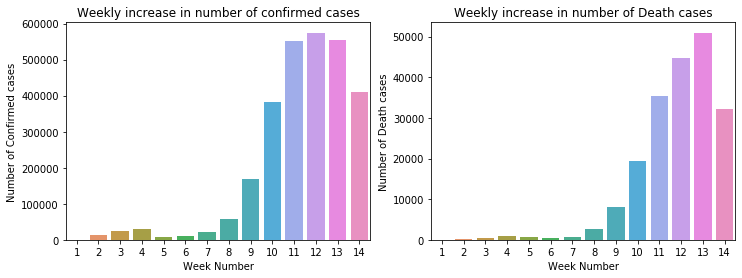

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel('Week Number')
ax2.set_xlabel('Week Number')
ax1.set_ylabel('Number of Confirmed cases')
ax2.set_ylabel('Number of Death cases')
ax1.set_title('Weekly increase in number of confirmed cases')
ax2.set_title('Weekly increase in number of Death cases')
plt.show()

Average increase in number of confirmed cases everyday: 29900.0
Average increase in number of recovered cases everyday: 8442.0
Average increase in number of Death cases everyday: 2097.0


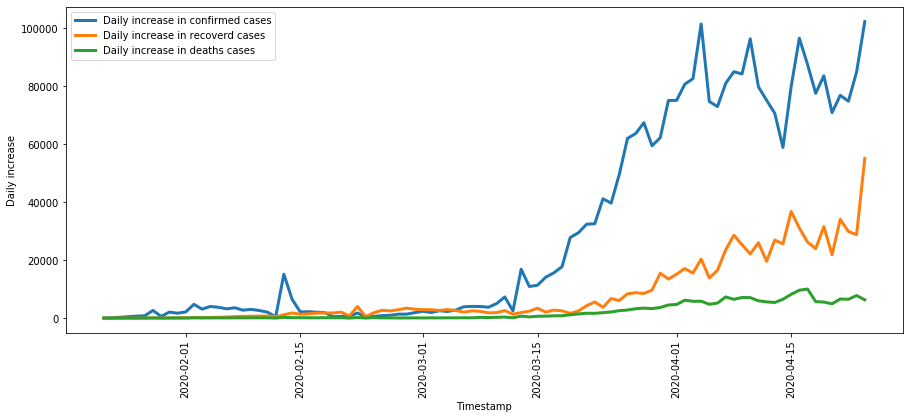

In [14]:
print('Average increase in number of confirmed cases everyday:',np.round(datewise['Confirmed'].diff().fillna(0).mean()))
print('Average increase in number of recovered cases everyday:',np.round(datewise['Recovered'].diff().fillna(0).mean()))
print('Average increase in number of Death cases everyday:',np.round(datewise['Deaths'].diff().fillna(0).mean()))
plt.figure(figsize=(15,6))
plt.plot(datewise['Confirmed'].diff().fillna(0),label='Daily increase in confirmed cases',linewidth=3)
plt.plot(datewise['Recovered'].diff().fillna(0),label='Daily increase in recoverd cases',linewidth=3)
plt.plot(datewise['Deaths'].diff().fillna(0),label='Daily increase in deaths cases',linewidth=3)
plt.xlabel('Timestamp')
plt.ylabel('Daily increase')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## Country Based Analysis

Calculating Country wise Mortality Rate

In [15]:
countrywise = covid[covid['ObservationDate']==covid['ObservationDate'].max()].groupby(['Country/Region']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'}).sort_values(['Confirmed'],ascending=False)
countrywise['Mortality']= (countrywise['Deaths']/countrywise['Recovered'])*100
countrywise['Recoverd'] = (countrywise['Recovered']/countrywise['Confirmed'])*100

Text(0.5, 1.0, 'Top 15 countries as per number of death cases')

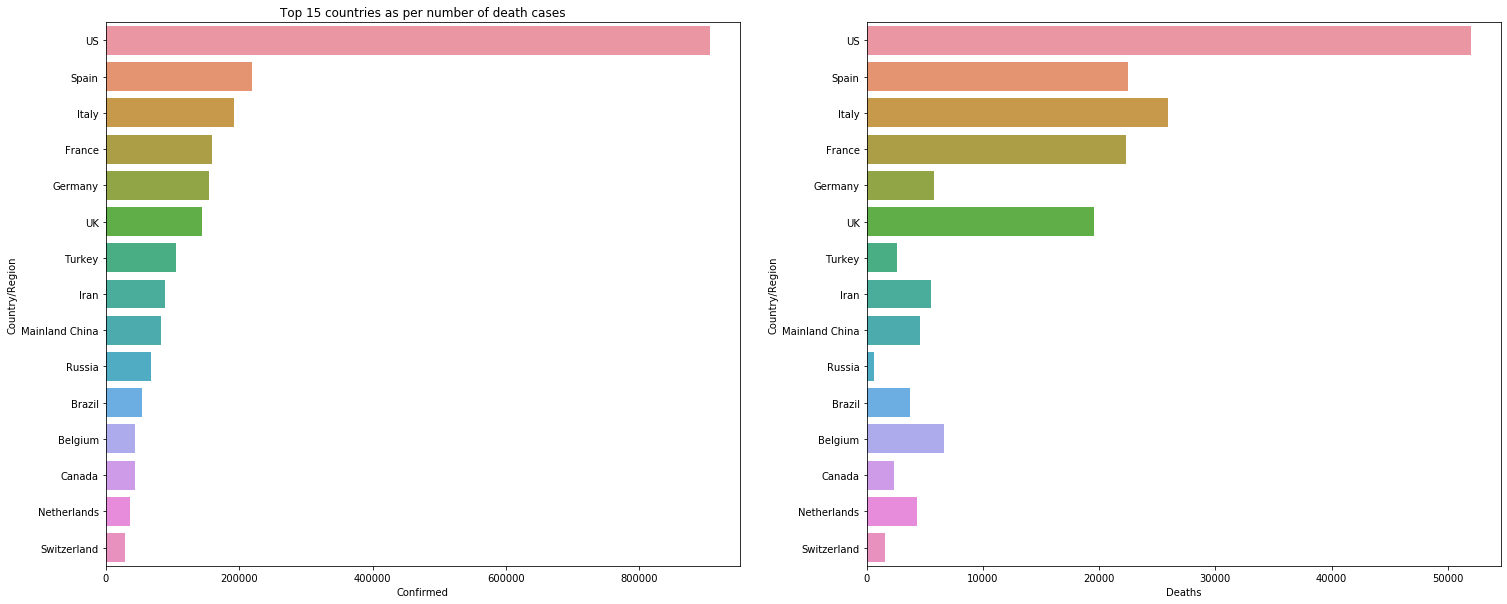

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25,10))
top_15confirmed = countrywise.sort_values(['Confirmed'],ascending=False).head(15)
top_15deaths = countrywise.sort_values(['Deaths'],ascending=False).head(15)
sns.barplot(x=top_15confirmed['Confirmed'],y=top_15confirmed.index,ax=ax1)
ax1.set_title('Top 15 countries as per number of confirmed cases')
sns.barplot(x=top_15confirmed['Deaths'],y=top_15confirmed.index,ax=ax2)
ax1.set_title('Top 15 countries as per number of death cases')

Data Analysis for India

In [17]:
india_data = covid[covid['Country/Region']=='India']
datewise_india = india_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
print(datewise_india.iloc[-1])
print('Total Active Cases',datewise_india['Confirmed'].iloc[-1]-datewise_india['Recovered'].iloc[-1]-datewise_india['Deaths'].iloc[-1])
print('Total Closed Cases',datewise_india['Recovered'].iloc[-1]+datewise_india['Deaths'].iloc[-1])


Confirmed    24530.0
Recovered     5498.0
Deaths         780.0
Name: 2020-04-24 00:00:00, dtype: float64
Total Active Cases 18252.0
Total Closed Cases 6278.0


Data Analysis for USA

In [18]:
us_data = covid[covid['Country/Region']=='US']
datewise_us = us_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
print(datewise_us.iloc[-1])
print('Total Active Cases',datewise_us['Confirmed'].iloc[-1]-datewise_us['Recovered'].iloc[-1]-datewise_us['Deaths'].iloc[-1])
print('Total Closed Cases',datewise_us['Recovered'].iloc[-1]+datewise_us['Deaths'].iloc[-1])


Confirmed    905333.0
Recovered     99079.0
Deaths        51949.0
Name: 2020-04-24 00:00:00, dtype: float64
Total Active Cases 754305.0
Total Closed Cases 151028.0


Text(0.5, 1.0, 'Weekly progress of different types of cases')

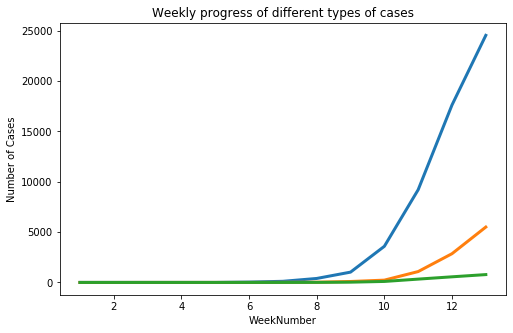

In [19]:
datewise_india['WeekofYear'] = datewise_india.index.weekofyear
week_num_india = []
india_weekwise_confirmed = []
india_weekwise_recovered = []
india_weekwise_deaths = []
w=1
for i in list(datewise_india['WeekofYear'].unique()):
    india_weekwise_confirmed.append(datewise_india[datewise_india['WeekofYear']==i]['Confirmed'].iloc[-1])
    india_weekwise_recovered.append(datewise_india[datewise_india['WeekofYear']==i]['Recovered'].iloc[-1])
    india_weekwise_deaths.append(datewise_india[datewise_india['WeekofYear']==i]['Deaths'].iloc[-1])
    week_num_india.append(w)
    w=w+1
plt.figure(figsize=(8,5))
plt.plot(week_num_india,india_weekwise_confirmed,linewidth=3)
plt.plot(week_num_india,india_weekwise_recovered,linewidth=3)
plt.plot(week_num_india,india_weekwise_deaths,linewidth=3)
plt.xlabel('WeekNumber')
plt.ylabel('Number of Cases')
plt.title('Weekly progress of different types of cases')

Number of days taken 

In [30]:
max_ind = datewise_india['Confirmed'].max()
china_data = covid[covid['Country/Region']=='Mainland China']
Italy_data = covid[covid['Country/Region']=='Italy']
US_data = covid[covid['Country/Region']=='US']
spain_data = covid[covid['Country/Region']=='Spain']
datewise_china = china_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
datewise_Italy = Italy_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
datewise_US = US_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
datewise_Spain = spain_data.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
print('It took',datewise_india[datewise_india['Confirmed']>0].shape[0],'days in India to reach',max_ind,'Confirmed Cases')
print('It took',datewise_Italy[datewise_Italy['Confirmed']>0&(datewise_Italy['Confirmed']<=max_ind)].shape[0],'days in Italy to reach number of Confirmed Cases')
print('It took',datewise_US[datewise_US['Confirmed']>0&(datewise_US['Confirmed']<=max_ind)].shape[0],'days in US to reach number of Confirmed Cases')
print('It took',datewise_Spain[datewise_Spain['Confirmed']>0&(datewise_Spain['Confirmed']<=max_ind)].shape[0],'days in Spain to reach number of Confirmed Cases')
print('It took',datewise_china[datewise_china['Confirmed']>0&(datewise_china['Confirmed']<=max_ind)].shape[0],'days in china to reach number of Confirmed Cases')


It took 86 days in India to reach 24530.0 Confirmed Cases
It took 85 days in Italy to reach number of Confirmed Cases
It took 94 days in US to reach number of Confirmed Cases
It took 84 days in Spain to reach number of Confirmed Cases
It took 94 days in china to reach number of Confirmed Cases


## Model Prediction

In [31]:
datewise['Days Since'] = datewise.index-datewise.index[0]
datewise['Days Since'] = datewise['Days Since'].dt.days
train_ml = datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml = datewise.iloc[:int(datewise.shape[0]*0.95):]
model_scores = []

Linear Regression

In [33]:
lin_reg = LinearRegression(normalize=True)
svm = SVR(C=1,degree=5,kernel='poly',epsilon=0.001)
lin_reg.fit(np.array(train_ml['Days Since']).reshape(-1,1),np.array(train_ml['Confirmed']).reshape(-1,1))
svm.fit(np.array(train_ml['Days Since']).reshape(-1,1),np.array(train_ml['Confirmed']).reshape(-1,1))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.001, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:
prediction_valid_lin_reg = lin_reg.predict(np.array(valid_ml['Days Since']).reshape(-1,1))
prediction_valid_svm = svm.predict(np.array(valid_ml['Days Since']).reshape(-1,1))

In [45]:
new_date = []
new_prediction_lr = []
new_prediction_svm = []
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise['Days Since'].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise['Days Since'].max()+i).reshape(-1,1))[0])
pd.set_option('display.float_format',lambda x: '%.f'%x)
model_predictions = pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_svm),columns=['Dates','LR','SVR'])
model_predictions.head(10)

,Dates,LR,SVR
0,2020-04-25,1560529,3322586
1,2020-04-26,1582219,3500761
2,2020-04-27,1603909,3686599
3,2020-04-28,1625599,3880344
4,2020-04-29,1647289,4082245
5,2020-04-30,1668980,4292557
6,2020-05-01,1690670,4511540
7,2020-05-02,1712360,4739461
8,2020-05-03,1734050,4976588
9,2020-05-04,1755740,5223200
